In [99]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

import numpy as np
import math
from typing import Sequence
#import tensorflow_probability.substrates.jax as tfp

import matplotlib.pyplot as plt

import tensorflow_probability.substrates.jax as tfp

In [2]:
# let's learn a bunch of mles and fishers over a prior

In [110]:
# simulator

import jax.random as jr

n_p = 2
n_d = 100
input_shape = (n_d,)

@jax.jit
def Fisher(θ, n_d=n_d):
    Σ = θ[1]
    return jnp.array([[n_d / Σ, 0.], [0., n_d / (2. * Σ**2.)]])


def simulator(key, θ):
    return θ[0] + jax.random.normal(key, shape=input_shape) * jnp.sqrt(θ[1])


key = jr.PRNGKey(0)

key1,key2 = jr.split(key)

mu_ = jr.uniform(key1, shape=(10000,), minval=-2, maxval=2)
sigma_ = jr.uniform(key2, shape=(10000,), minval=0.5, maxval=3.0)

theta_ = jnp.stack([mu_, sigma_], axis=-1)

keys = jr.split(key, num=10000)
data = jax.vmap(simulator)(keys, theta_)[:, :]

In [4]:
data.shape

(10000, 100)

In [181]:
#@title fishnets code

def fill_triangular(x):
    m = x.shape[0] # should be n * (n+1) / 2
    # solve for n
    n = int(math.sqrt((0.25 + 2 * m)) - 0.5)
    idx = (m - (n**2 - m))

    x_tail = x[idx:]

    return jnp.concatenate([x_tail, jnp.flip(x, [0])], 0).reshape(n, n)

def fill_diagonal(a, val):
    a = a.at[..., jnp.arange(0, a.shape[0]), jnp.arange(0, a.shape[0])].set(val)

    return a

def construct_fisher_matrix_single(outputs):
    Q = fill_triangular(outputs)
    middle = jnp.diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
    padding = jnp.zeros(Q.shape)

    L = Q - fill_diagonal(padding, middle)

    return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (1, 0)))

# def construct_fisher_matrix_single(outputs):
#     Q = tfp.math.fill_triangular(outputs)
#     middle = jnp.diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
#     padding = jnp.zeros(Q.shape)

#     L = Q - fill_diagonal(padding, middle)

#     return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (1, 0)))

def construct_fisher_matrix_multiple(outputs):
    Q = jax.vmap(fill_triangular)(outputs)
    # vmap the jnp.diag function for the batch
    _diag = jax.vmap(jnp.diag)

    middle = _diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
    padding = jnp.zeros(Q.shape)

    # vmap the fill_diagonal code
    L = Q - jax.vmap(fill_diagonal)(padding, middle)

    return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (0, 2, 1)))


In [182]:
class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.elu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x


class fishnets_MLP(nn.Module):
  features: Sequence[int]
  n_p: int

  @nn.compact
  def __call__(self, x):

    x = x[:, jnp.newaxis]

    for feat in self.features:
      x = nn.swish(nn.Dense(feat)(x))
    outdim = self.n_p + (self.n_p * (self.n_p + 1) // 2)
    x = nn.Dense(outdim)(x)

    score = x[..., :self.n_p]
    fisher = x[..., self.n_p:]

    #print(fisher.shape)

    fisher = (construct_fisher_matrix_multiple(fisher))
    fisher = fisher.sum(0)
    fisher += jnp.eye(self.n_p)
    score = score.sum(0)
    mle = jnp.einsum('...jk,...k->...j', jnp.linalg.inv(fisher), score)



    return mle,fisher


class FishnetDeepset(nn.Module):
  theta_fid: jnp.array
  n_hidden_score: list
  n_hidden_fisher: list
  n_hidden_globals: list
  n_inputs: int=1
  n_parameters: int=2
  is_iid: bool=True
  priorCinv: jnp.array = jnp.eye(2)
  priormu: jnp.array = jnp.zeros((2,))

  def setup(self):

      self.model_score = MLP(self.n_hidden_score)
      self.model_fisher = MLP(self.n_hidden_fisher)
      self.model_globals = MLP(self.n_hidden_globals + (int(self.n_parameters \
                                      + int(self.n_parameters * (self.n_parameters + 1)) // 2),)
                                          )


  def __call__(self, x):

      x = x[..., jnp.newaxis]

      score = self.model_score(x) #[:, jnp.newaxis]
      fisher_cholesky = self.model_fisher(x) #[:, jnp.newaxis]

      #print(score.shape)

      t = jnp.mean(score, axis=0) #- jnp.einsum('ij,j->i', self.priorCinv, (self.theta_fid - self.priormu))
      fisher_cholesky = jnp.mean(fisher_cholesky, axis=0)

      #print("t", t.shape)
      #print("fisher", fisher_cholesky.shape)

      outputs = self.model_globals(jnp.concatenate([t, fisher_cholesky], axis=-1))


      t = outputs[:self.n_parameters]
      fisher_cholesky = outputs[self.n_parameters:]

      #
      # print("fisher cholesky", fisher_cholesky.shape)

      F = construct_fisher_matrix_single((fisher_cholesky)) + self.priorCinv
      # #+ self.priorCinv

      #mle = t
      mle = t #self.theta_fid + t #jnp.einsum('jk,k->j', jnp.linalg.inv(F), t)

      return mle, F




In [183]:
key = jax.random.PRNGKey(0)

model = FishnetDeepset(jnp.ones(2,),
                n_hidden_fisher=[128,128],
                n_hidden_score=[128,128],
                n_hidden_globals=[50,50],
                n_inputs=1,
                n_parameters=2,
                is_iid=True)

w = model.init(key, jnp.ones((10,)))

mle, F = model.apply(w, jnp.ones((10,)))

In [184]:
F, mle

(Array([[ 1.7194873, -0.5037565],
        [-0.5037565,  2.3502917]], dtype=float32),
 Array([0.06356296, 0.3846492 ], dtype=float32))

In [185]:
F, mle

(Array([[ 1.7194873, -0.5037565],
        [-0.5037565,  2.3502917]], dtype=float32),
 Array([0.06356296, 0.3846492 ], dtype=float32))

In [186]:
@jax.jit
def kl_loss(w, x_batched, theta_batched):

    def fn(x, theta):
       mle,F = model.apply(w, x)
       return mle, F

    mle,F = jax.vmap(fn)(x_batched, theta_batched)

    return -jnp.mean(-0.5 * jnp.einsum('ij,ij->i', (theta_batched - mle), \
                                             jnp.einsum('ijk,ik->ij', F, (theta_batched - mle))) \
                                                  + 0.5*jnp.log(jnp.linalg.det(F)), axis=0)

In [187]:
from tqdm import tqdm
import optax
tx = optax.adam(learning_rate=1e-4)
opt_state = tx.init(w)
loss_grad_fn = jax.value_and_grad(kl_loss)


batch_size = 100
epochs = 100

w = w

losses = []

In [188]:
batch_size = 100

data_batched = data.reshape(-1, batch_size, n_d)
theta_batched = theta_.reshape(-1, batch_size, n_p)

In [189]:
def body_fun(i, inputs):
    w,loss_val, opt_state = inputs
    data_samples = data_batched[i]
    theta_samples = theta_batched[i]

    loss_val, grads = loss_grad_fn(w, data_samples, theta_samples)
    updates, opt_state = tx.update(grads, opt_state)
    w = optax.apply_updates(w, updates)

    return w, loss_val, opt_state

In [202]:
from tqdm import tqdm
#batch_size = 100

epochs = 1000

key = jax.random.PRNGKey(99)

# training loop shit
key = jax.random.PRNGKey(88)
losses = jnp.zeros(epochs)
detFetas = jnp.zeros(epochs)

loss_val = 0.
detFeta = 0.

lower = 0
upper = epochs // batch_size

counter = 0

pbar = tqdm(range(epochs), leave=True, position=0)

for j in pbar:
  key,rng = jax.random.split(key)
  inits = (w, loss_val, opt_state)

  w, loss_val, opt_state = jax.lax.fori_loop(lower, upper, body_fun, inits)

    #if i % 10 == 0:

    #  val_loss, _ = loss_grad_fn(w, X_test, y_test)
      #print('loss step {}: '.format(i), loss_val)
      #print('val loss step {}: '.format(i), val_loss_val)

  losses = losses.at[j].set(loss_val)
  #val_losses.append(val_loss)
  pbar.set_description('epoch loss %d: %.4f'%(j, loss_val))

epoch loss 999: -2.5579: 100%|██████████| 1000/1000 [00:23<00:00, 43.41it/s]


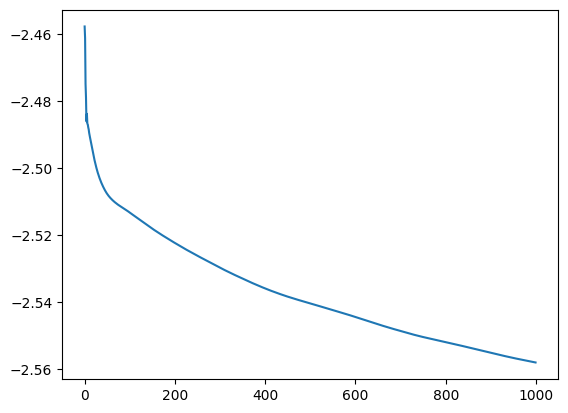

In [203]:
plt.plot(losses)

In [204]:
data[-1000:].shape

(1000, 100)

In [205]:
_appl = lambda d: model.apply(w, d)
mle_pred,F_pred = jax.vmap(_appl)(data[-1000:])

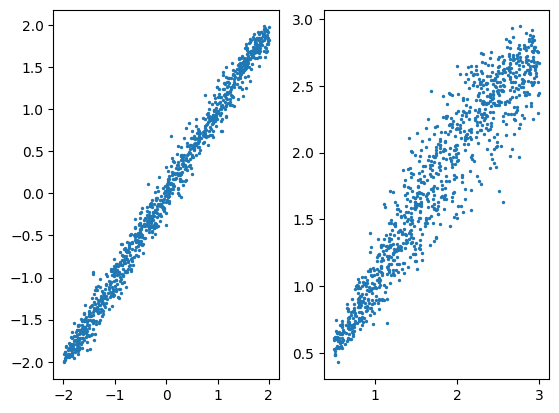

In [206]:
plt.subplot(121)
plt.scatter(theta_[-1000:, 0], mle_pred[:, 0], s=2)
plt.subplot(122)
plt.scatter(theta_[-1000:, 1], mle_pred[:, 1], s=2)

In [207]:
@jax.jit
def Fisher(θ, n_d=n_d):
    Σ = θ[1]
    return jnp.array([[n_d / Σ, 0.], [0., n_d / (2. * Σ**2.)]])

F_true = jax.vmap(Fisher)(theta_[-1000:])

In [208]:
F_true[:5]

Array([[[112.028824,   0.      ],
        [  0.      ,  62.75229 ]],

       [[192.69995 ,   0.      ],
        [  0.      , 185.66637 ]],

       [[ 50.47263 ,   0.      ],
        [  0.      ,  12.737433]],

       [[ 91.64879 ,   0.      ],
        [  0.      ,  41.9975  ]],

       [[ 46.800243,   0.      ],
        [  0.      ,  10.951315]]], dtype=float32)

In [209]:
F_pred[:5]

Array([[[212.33499   ,  -9.132244  ],
        [ -9.132244  ,  48.340645  ]],

       [[218.82745   ,  -6.511551  ],
        [ -6.511551  , 245.08559   ]],

       [[ 49.776344  ,   2.1967878 ],
        [  2.1967878 ,  13.156134  ]],

       [[ 90.81213   ,   0.67567253],
        [  0.67567253,  26.869349  ]],

       [[ 46.880554  ,   1.111887  ],
        [  1.111887  ,  14.5119705 ]]], dtype=float32)

In [210]:
θ_fid = jnp.array([0.0, 1.25])

lo = [-1.0, 0.5]
hi = [1.0, 3.0]

num = 10

xs = jnp.linspace(-1.0, 1.0, num) # MEAN
ys = jnp.linspace(0.5, 3.0, num) #jnp.logspace(-1.0, 0.0, num) # VARIANCE


xs,ys = jnp.meshgrid(xs, ys)

fishers = []

for _mu,_sigma in zip(xs.ravel(), ys.ravel()):
  fishers.append(Fisher(jnp.array([_mu,_sigma]), n_d=n_d))

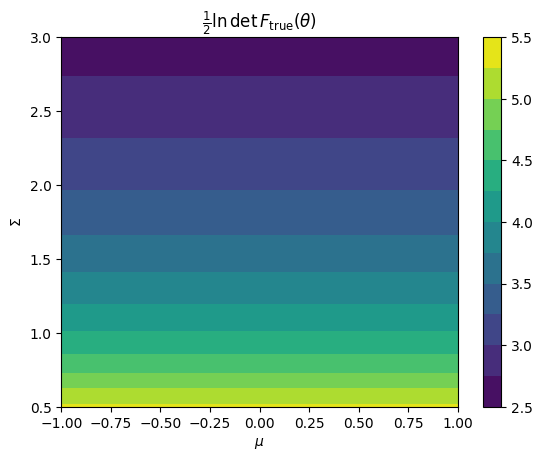

In [211]:
_data = jax.vmap(jnp.linalg.det)(jnp.array(fishers)).reshape(xs.shape) #/ ys #jnp.array(fishers)[:, 0, 0].reshape(xs.shape) / ys #jax.vmap(jnp.linalg.det)(jnp.array(fishers)).reshape(xs.shape)

im = plt.contourf(xs, ys, 0.5*np.log(_data), cmap='viridis', levels=10)
cbar = plt.colorbar(im)
#plt.yscale('log')
plt.ylabel('$\Sigma$')
plt.xlabel('$\mu$')
plt.title(r'$ \frac{1}{2} \ln \det F_{\rm true}(\theta)$')
plt.legend(framealpha=0., loc='lower left')
plt.show()

In [212]:
fishers_pred = []

key = jr.PRNGKey(99)
n_d_test = 500




for mu,sigma in tqdm(zip(xs.ravel(), ys.ravel())):
  # generate many data realization at each gridpoint
    key, rng = jr.split(key)
    keys = jr.split(key, 2000)

    sims = jax.vmap(simulator)(keys, jnp.tile(jnp.array([[mu], [sigma]]), 2000).T)

    #print(sims.shape)

    fpreds = jax.vmap(_appl)(sims)[1]

    fishers_pred.append(jnp.mean(fpreds, axis=0))

100it [00:10,  9.88it/s]


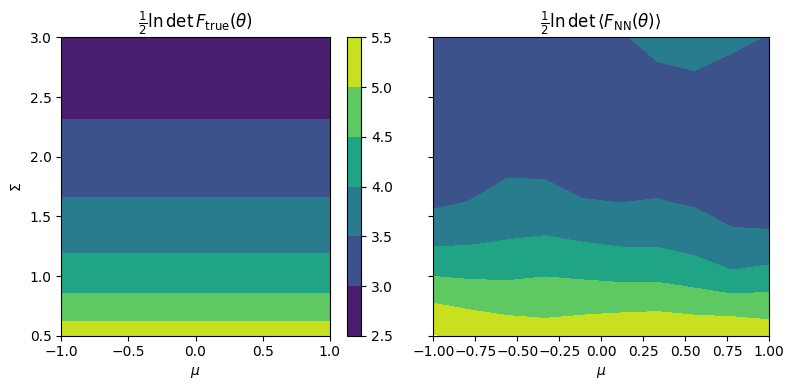

In [213]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharex="col", sharey=True)
(ax1, ax2) = axs

levels = [2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5]

dets1 =  jax.vmap(jnp.linalg.det)(jnp.array(fishers)).reshape(xs.shape)

cs1 = ax1.contourf(xs, ys, 0.5*np.log(dets1), cmap='viridis', levels=levels)

dets2 = jax.vmap(jnp.linalg.det)(jnp.array(fishers_pred)).reshape(xs.shape)

cs2 = ax2.contourf(xs, ys, 0.5*np.log(dets2), cmap='viridis', levels=levels)

plt.colorbar(cs1)

ax1.set_title(r'$ \frac{1}{2} \ln \det F_{\rm true}(\theta)$')

ax1.set_ylabel('$\Sigma$')
ax1.set_xlabel('$\mu$')

ax2.set_xlabel('$\mu$')
ax2.set_title(r'$ \frac{1}{2} \ln \det \langle F_{\rm NN}(\theta) \rangle $')
plt.tight_layout()

In [214]:
# create some new data and fishers and save them


@jax.jit
def Fisher(θ, n_d=n_d):
    Σ = θ[1]
    return jnp.array([[n_d / Σ, 0.], [0., n_d / (2. * Σ**2.)]])


def simulator(key, θ):
    return θ[0] + jax.random.normal(key, shape=input_shape) * jnp.sqrt(θ[1])


key = jr.PRNGKey(10000)

key1,key2 = jr.split(key)

mu_ = jr.uniform(key1, shape=(10000,), minval=-2, maxval=2)
sigma_ = jr.uniform(key2, shape=(10000,), minval=0.5, maxval=3.0)

theta_test = jnp.stack([mu_, sigma_], axis=-1)

keys = jr.split(key, num=10000)
data_test = jax.vmap(simulator)(keys, theta_test)[:, :]

# calculate network fisher over all the data
mle_out, F_network_out = jax.vmap(_appl)(data_test)

# calculate true fisher at the same theta
F_true_out = jax.vmap(Fisher)(theta_test)

In [218]:
data_test.shape

(10000, 100)

In [220]:
# save everything
np.savez("toy_problem_outputs",
         #data=data_test,
         mle=mle_out,
         theta=theta_test,
         F_network=F_network_out,
         F_true=F_true_out
         )